# Variational Autoencoders

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [2]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
matplotlib 3.0.2
numpy 1.14.6
pandas 0.22.0
sklearn 0.20.2
tensorflow 1.12.0
tensorflow._api.v1.keras 2.1.6-tf


In [0]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
from functools import partial

my_dense_layer = partial(tf.layers.dense, activation = tf.nn.elu, kernel_initializer = initializer)

In [0]:
X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation = None)
outputs = tf.sigmoid(logits)

In [0]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

We now use this variational autoencoder to generate images that look like handwritten digits. We train the model then sample random codings from a Gaussian distribution and decode them.

In [11]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      print("\r{}%".format(100*iteration//n_batches), end='')
      sys.stdout.flush()
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X:X_batch})
    loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
    print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
    saver.save(sess, "./my_model_variational.ckpt")
        
  codings_rnd = np.random.normal(size = [n_digits, n_hidden3])
  outputs_val = outputs.eval(feed_dict={hidden3:codings_rnd})

0 Train total loss: 17546.7 	Reconstruction loss: 13904.729 	Latent loss: 3641.9697
1 Train total loss: 16779.492 	Reconstruction loss: 13168.305 	Latent loss: 3611.1868
2 Train total loss: 16563.945 	Reconstruction loss: 12763.29 	Latent loss: 3800.6558
3 Train total loss: 16322.432 	Reconstruction loss: 12567.857 	Latent loss: 3754.5747
4 Train total loss: 16294.567 	Reconstruction loss: 12544.042 	Latent loss: 3750.5251
5 Train total loss: 16505.574 	Reconstruction loss: 12721.098 	Latent loss: 3784.4756
6 Train total loss: 16215.416 	Reconstruction loss: 12324.869 	Latent loss: 3890.5466
7 Train total loss: 16143.557 	Reconstruction loss: 12383.885 	Latent loss: 3759.6719
8 Train total loss: 15918.823 	Reconstruction loss: 12158.075 	Latent loss: 3760.748
9 Train total loss: 15797.956 	Reconstruction loss: 11997.391 	Latent loss: 3800.5654
10 Train total loss: 15328.6875 	Reconstruction loss: 11585.238 	Latent loss: 3743.4492
11 Train total loss: 15628.613 	Reconstruction loss: 118

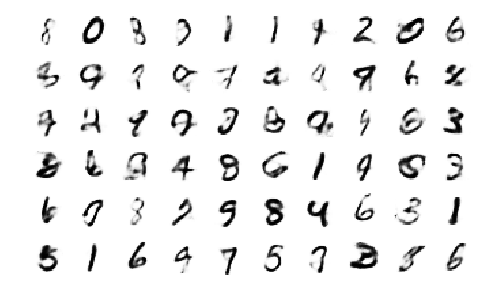

In [12]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

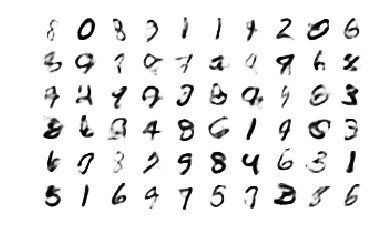

In [17]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()